In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 4 - Fall 2019
## Due 9 AM, Monday 11 Nov, 2019

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


**1.** Let's compare our dimensionalized, Barnes-style weight function to Gaussian function in `scipy.signal.windows.gaussian`. We understand its nondimensional frequency response quite well using theory from Koch, Trapp and Doswell, etc. However, the functions in `scipy.signal.windows.gaussian` control the cutoff in terms of the standard deviation. Since the functions are mathmatically equivalent, we should be able to reconcile them.

**a.** Using a data spacing of $\Delta=10$ m, what is the nyquist length scale $L_n$, and the spatial sampling frequency $f_s$ and nyquist $f_n$?


In [4]:
delta = 10 #units in meters
Ln = 2*delta
fs = 1/0.5
fn = 1/(Ln)

Let's assume we have $N=2047$ samples of data and sample at evenly spaced locations $x$ from $0$ to $(N-1)\Delta$.

To get a feel for what data looks like in the frequncy domain transform, let's look at a step function, a linear ramp, and a sine wave. The function provided below calcualtes the Fourier transform and plots its amplitude and phase response. You'll use this plot for the rest of the assignment.

**b.** There is no waviness to the ramp. Why is there amplitude at so many frequencies?

**Answer:** 

**c.** When you run the code to show the FFT of the sine wave, why is there amplitude at more than a single frequency?

**Answer:** 

0.0 20450.0
4.887585532746823e-05 0.0009775171065493646
-0.05 0.04995112414467253 0.05
-20460.0 20460.0


<ipython-input-6-41f57b1c858c>:25: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq
<ipython-input-6-41f57b1c858c>:15: RuntimeWarning: divide by zero encountered in log10
  return 10.0*np.log10(a/base)


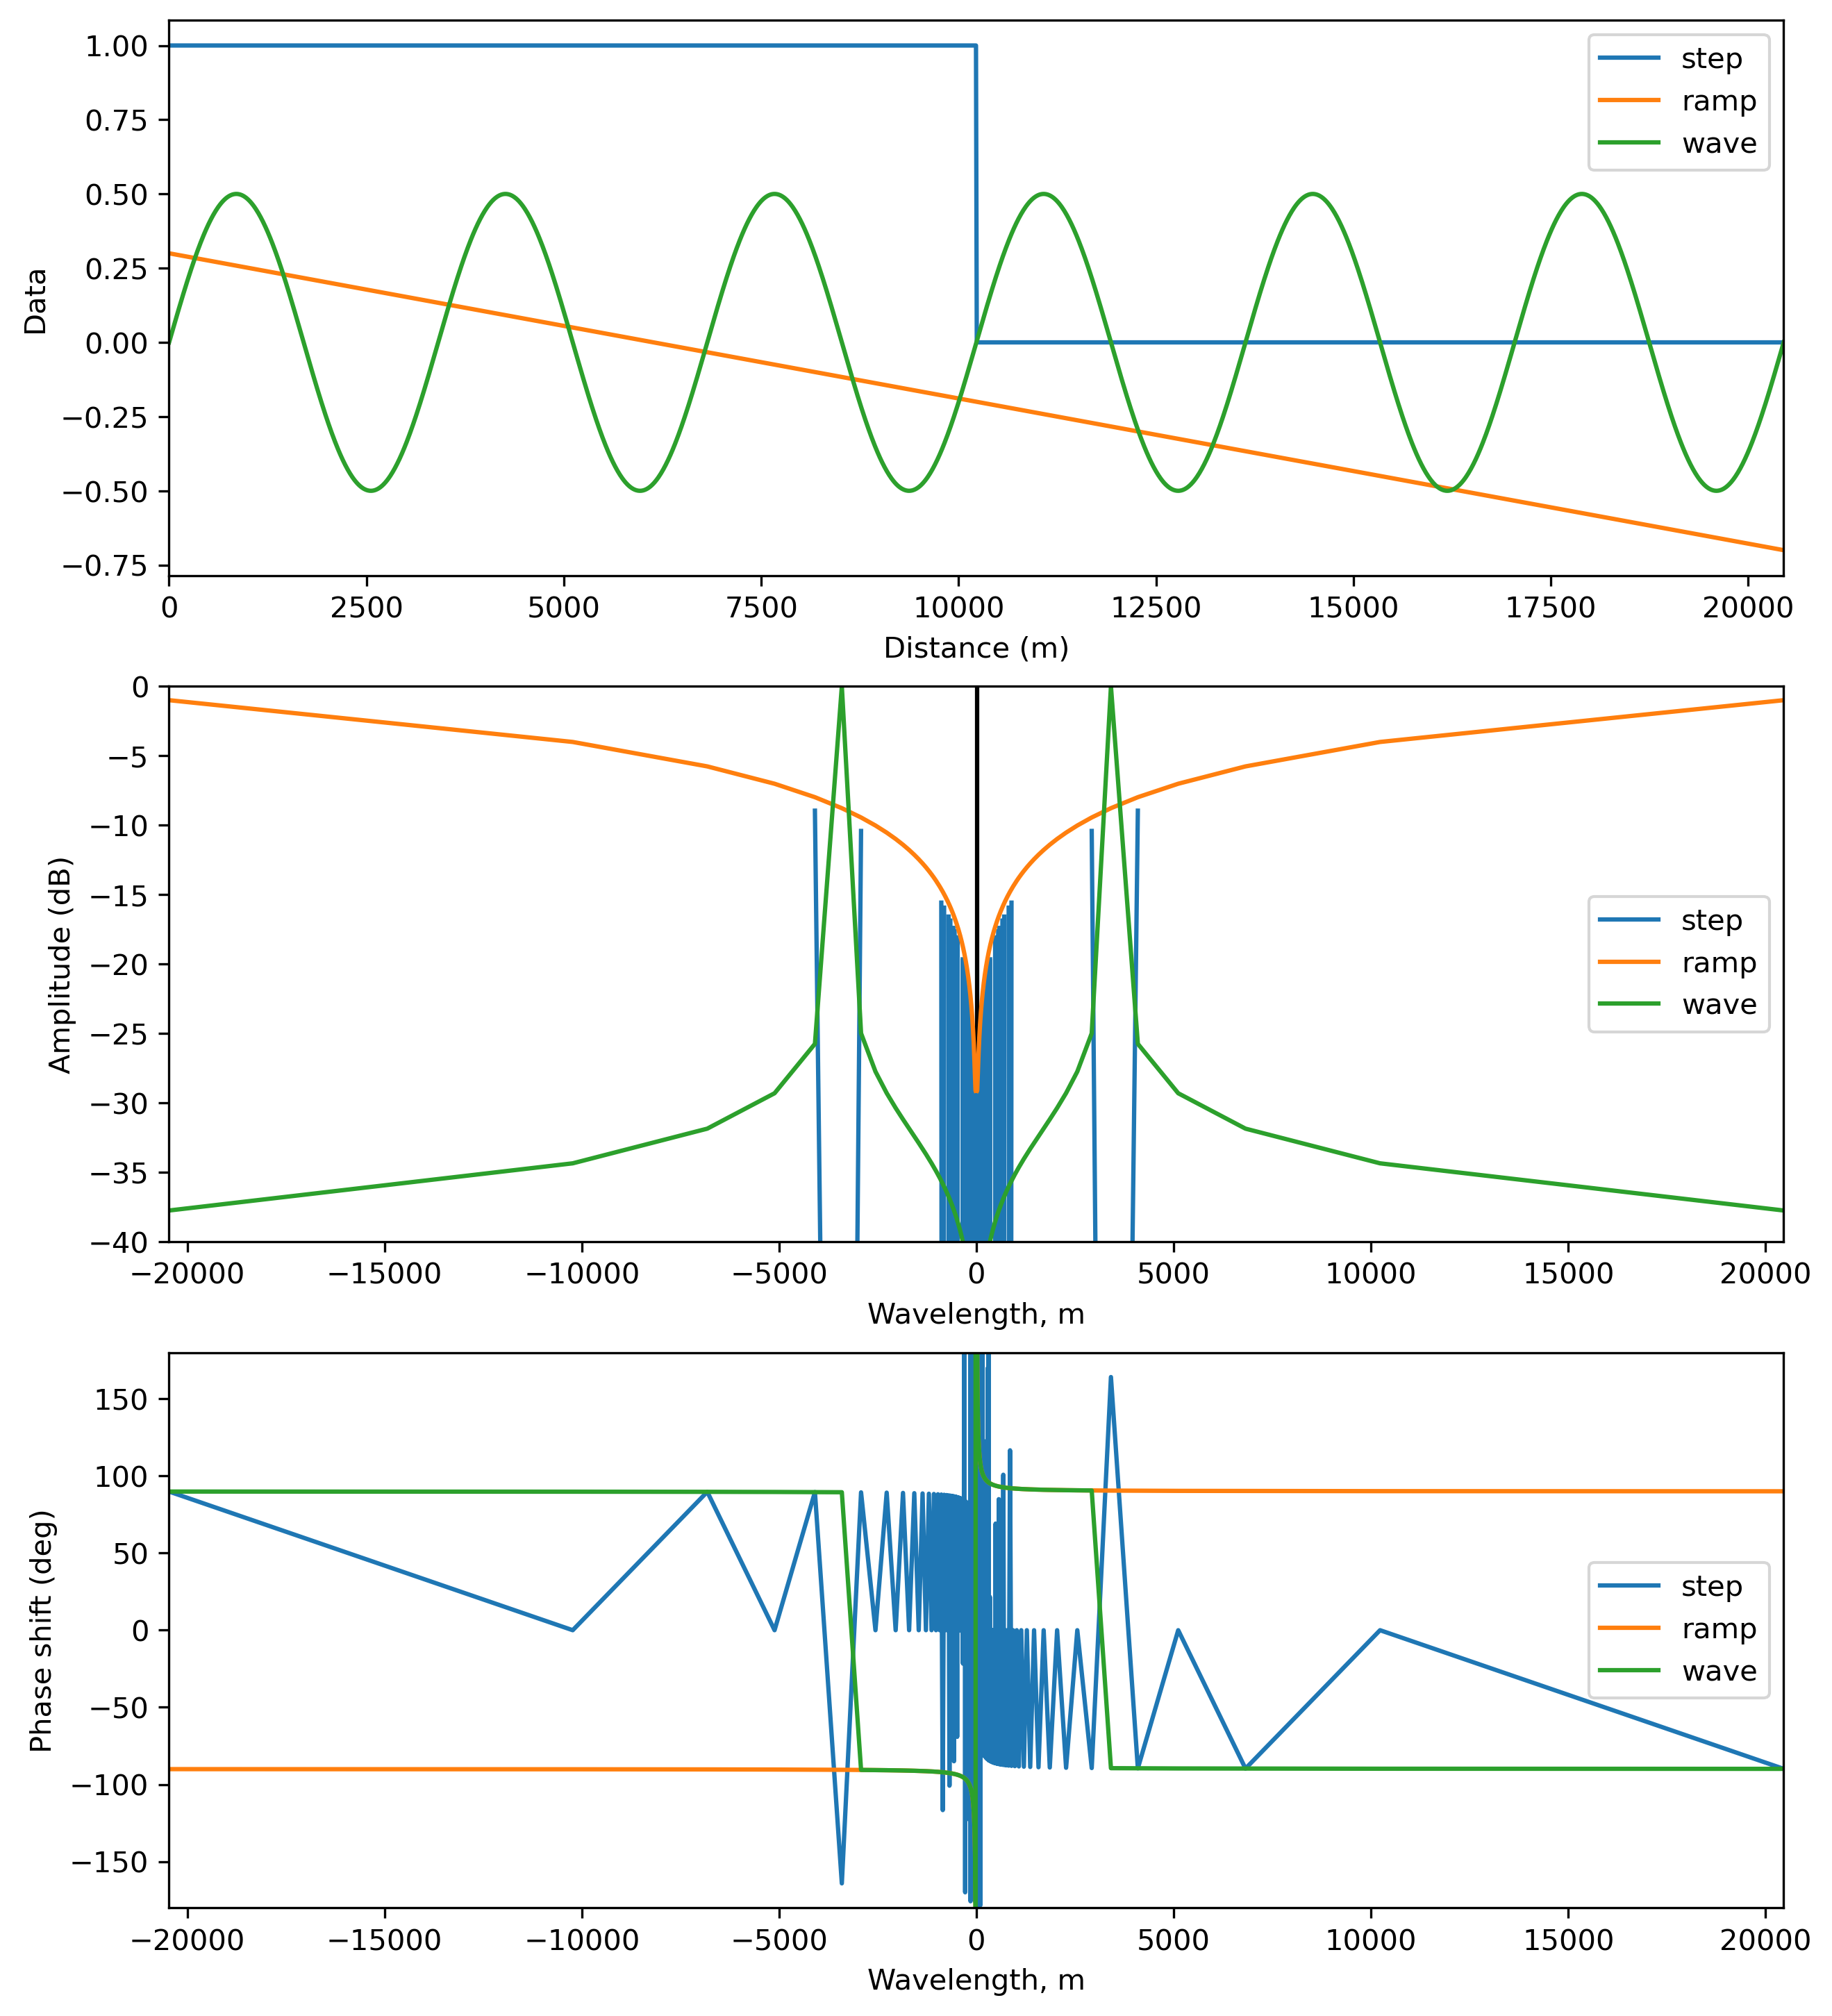

In [6]:
N = 2046
x = np.arange(N, dtype='f8')*delta
print(x.min(), x.max())

freqs = np.fft.fftfreq(N, delta)
df = freqs[1]-freqs[0]
# frequency interval is the same as that calculated theoretically from fs/N
print(df, fs/N)
# and so is the Nyquist
print(freqs.min(), freqs.max(), fn)

fftshift = np.fft.fftshift

def dB(a,base=1.0):
    return 10.0*np.log10(a/base)

def response_plot(signals, x, axs, freq, labels=None, wavelength=False, dB_amp=True):
    """ Signals is a tuple or list (or iterable) of signals.
    """
    if labels is None:
        labels = range(len(signals))
    ax_t, ax_f, ax_p = axs
    
    if wavelength:
        freqs = 1.0/freq
        freq_label = 'Wavelength, m' 
        fmin, fmax = np.nanmin(freqs), -np.nanmin(freqs)
        for ax in [ax_f, ax_p]: ax.axvline(Ln, color='k')
    else:
        freqs = freq
        freq_label = 'Spatial Frequency, m^-1' 
        fmin, fmax = np.nanmin(freqs), np.nanmax(freqs)
    print(fmin, fmax)
    
    for signal, label in zip(signals, labels):
        fft_s = np.fft.fft(signal/signal.sum(), signal.shape[0])
        amplitude = np.abs(fftshift(fft_s))
        amplitude /= amplitude.max()
        phase = np.angle(fftshift(fft_s))
        
#         print(amplitude.max(), amplitude.min(), np.all(~np.isfinite(amplitude)))
#         print(phase.max(), phase.min())

        ax_t.plot(x, signal, label=label)
        ax_t.set_ylabel('Data')
        ax_t.set_xlabel('Distance (m)')
        ax_t.set_xlim(x.min(), x.max())
        john = ax_t.legend()

        if dB_amp:
            ax_f.plot(fftshift(freqs), dB(amplitude), label=label)
            ax_f.set_ylim(-40,0)
            ax_f.set_ylabel('Amplitude (dB)')
        else:
            ax_f.plot(fftshift(freqs), amplitude, label=label)
            ax_f.set_ylim(0,1)
            ax_f.set_ylabel('Amplitude (linear)')
        ax_f.set_xlim(fmin, fmax)
        ax_f.set_xlabel(freq_label)
        john = ax_f.legend()

        ax_p.plot(fftshift(freqs), np.degrees(phase), label=label)
        ax_p.set_ylim(-180,180)
        ax_p.set_xlim(fmin, fmax)
        ax_p.set_ylabel('Phase shift (deg)')
        ax_p.set_xlabel(freq_label)
        john = ax_p.legend()
        

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

step = np.zeros_like(x)
step[:int(N/2)] = 1.0

ramp = -x/x.max() + 0.3

wave = np.sin(x*12*np.pi/x.max())/2

signals = [step, ramp, wave]
labels = ['step', 'ramp', 'wave']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)

**2.** 

**a.** Implment the Barnes distance-dependent weighting function for $\kappa^* = 0.1$ and $0.5$. Center the weight function in the middle of the time series.

**b.** Simulate an artificial cutoff radius by setting any weights with value less than 0.1 to zero. This will give you four weight functions, two for each $\kappa^*$.

**c.** Use the `response_plot` function provided above to plot the four weight functions and their frequency domain response. Plot in wavelength mode, and zoom in to wavelengths between 0 and 200 (you don't need to show the negative wavelengths).

[1.00000000e+00 8.20849986e-02 4.53999298e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[1.         0.60653066 0.13533528 ... 0.         0.         0.        ]


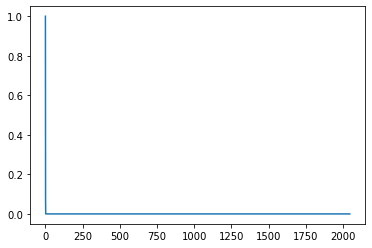

In [20]:
#Part A
def barnes(r, k):
    """ r has units of distance, and k is the dimensional weight parameter kappa
        kappa with units of distance squared.
        
        Returns the weights as a funcion of r.
    """
    pass 
    w = np.exp((-r**2)/((4*(delta**2))*k))
    w_norm = np.exp(-k*((np.pi/k)**2))
    
    return w, w_norm

r_1 = np.sqrt(0.1)
r_2 = np.sqrt(0.5)

w_1, w_norm_1 = barnes(x , 0.1)
w_2, w_norm_2 = barnes(x , 0.5)

print(w_1)
print(w_2)

from scipy.signal.windows import gaussian


# your other code here.

**3.** Instead of weighting with the distance dependent weighting function you wrote, let's use the built-in Gaussian function: `from scipy.signal.windows import gaussian`. It is formulated in terms of the standard deviation. In lecture we derived the relationship $\sigma = \sqrt{2\kappa^*}$. 

Reproduce your plot above using the built-in Gaussian window (weight) function.

In [ ]:
from scipy.signal.windows import gaussian

# your code here

**4.** Implement and plot the frequency response for 3- and 5-point rectangular weight (boxcar) functions.

In [ ]:
# your code here

**5.** Implement and plot a 5-point Parzen (Riesz) weight function. Also show the effect of an artifical cutoff by removing the weights below 0.1.

In [ ]:
from scipy.signal.windows import parzen

# your code here

**6.** Implement and plot a 5-point Dolph-Chebyshev weight function with a lowest sidelobe level of 60 dB. Also show the effect of an artifical cutoff by removing the weights below 0.1.

In [ ]:
from scipy.signal.windows import chebwin

# your code here

**7.** Implement and plot a 7-point Blackman and a 7-point Blackman-Harris weight function. There is no need to show the effect of an artificial cutoff here.

In [ ]:
from scipy.signal.windows import blackmanharris, blackman

# your code here

**8.** 

**a.** Plot all weight functions together on the same graph, excluding those that show the effect of an artificial cutoff. Use  `dB_amp=False` to show the amplitude response in linear units.

**b.** Assume our critiera for a best analysis ranks our priorties as follows:
1. Smooth frequency response
2. Minimum amplitude at the Nyquist
3. Maximum amplitude at relatively small wavelengths just next to the Nyquist

Which weight functions are worst by these critera?

Which weight function do you regard as best, and why?

**c.** Compare the Nyquist-crossing amplitudes of the two Gaussian weight functions to the values in Koch et al. (1983), Fig. 1. How does each crossing point differ? What is the reason for the differences?

In [ ]:
# your plotting code here